<a href="https://colab.research.google.com/github/DionesGouvea/Identificacao-de-fraudes/blob/main/Identificacao_de_fraudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Contexto analíico
O banco xxxxxxx quer diminuir os casos de fraudes em suas transações bancárias atualmente o banco conta com um algoritimo que não identifica a maioria das operações fraudulentas, gerando grandes percas.

**Objetivo 1:** entregar um modelo que identifique o maior número de casos de fraude e que tenha o melhor trade off possível entre transações reais x fraudes. 

Além de ter um modelo que identifique as fraudes é preciso que ele realize inferencias no menor tempo possível.

**Objetivo 2** Aplicar o uso de GPU para o modelo em busca de um tempo de inferência menor.  

##Dados

O conjunto de dados é uma simulação feita com base em uma amostra de transações reais, extraidas de um mês de registros financeiros de um serviço de dinheiro movel implementado em um pais africano. Os registros originais foram fornecidos por uma empresa multinacional, que é a provedora do serviço financeiro móvel que atualmente está sendo executado em mais de 14 países em todo o mundo.

Para saber mais como esses dados foram gerados e também um entendimento melhor sobre suas variaveis pode se ler este artigo [PAYSIM: UM SIMULADOR DE DINHEIRO MÓVEL FINANCEIRO PARA DETECÇÃO DE FRAUDES](https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION)

Features:
- **step** - representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744 (30 dias);

- **type** - Tipo: tipo de transação (depósito, saque, débito, pagamento e transferência);

- **amount** - total que foi transacionado;

- **nameOrig** - cliente que iniciou a transação

- **oldbalanceOrg** - saldo da conta de origem antes da transação;

- **newbalanceOrig** - saldo da conta de origem após a transação;

- **nameDest** - cliente de destino da transação;

- **oldbalanceDest** - saldo da conta de destino antes da transação;

- **newbalanceDest** - saldo da conta de destino após a transação;

- **isFraud** - flag que define se a transação é fraudulenta ou não. Nesta simulação o objetivo da fraude é assumir a conta do usuário, esvaziá-la transferindo para outra conta e então sacando o dinheiro.

- **isFlaggedFraud** - automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

## Importando os Dados


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
from google.colab import drive 
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Tera/Data/fraud_detection_dataset.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
df.info(null_counts= True)

<ipython-input-7-07af6ba031d6>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts= True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Analise Exploratoria 


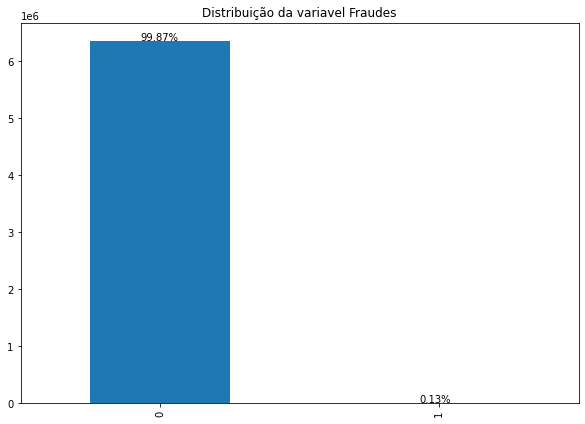

In [ ]:
#verificando a ditribuição da nossa variavel target 
ax = df['isFraud'].value_counts().plot(kind = 'bar',figsize = (10,7))
ax.set_title('Distribuição da variavel Fraudes')
for p in ax.patches: # patches pega as colunas 
  #multiplicando o tamanho da coluna por 100 e dividindo pelo tamanho da variavel isfraud
  ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.isFraud)), (p.get_x()+ 0.18, p.get_height()))

As transações fraudulentas representão apenas 0,13% do total de transações porem mesmo com um percentual baixo podem significar um prejuizo grande.

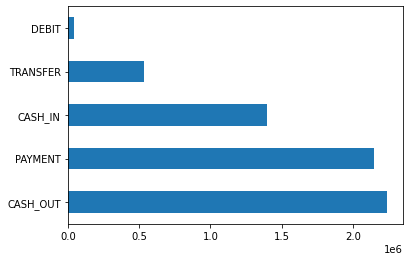

In [ ]:
#visualizando a distribuição por tipo de operação 
df['type'].value_counts().plot(kind = 'barh')

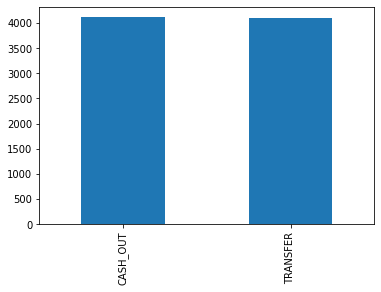

In [ ]:
#visualizando a distribuição entre as operaçãões com fraudes 
df[df.isFraud == 1]['type'].value_counts().plot(kind = 'bar')

Já podemos perceber que só houve fraude em operações do tipo transferencia e saque 

Text(0.5, 1.0, 'CASH_OUT')

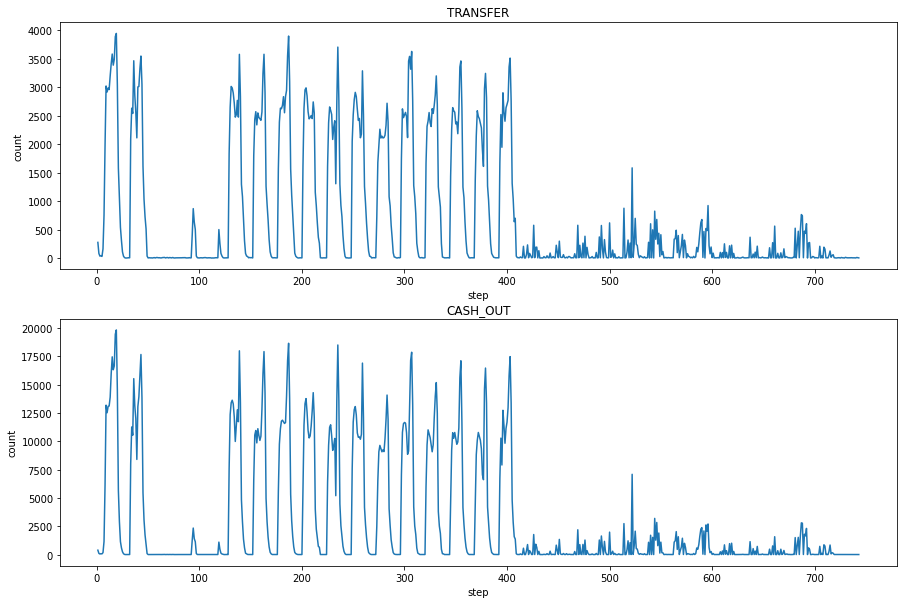

In [68]:
#visualizando as operações Cash_out e TRANSFER no decorrer do mês 
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
df[df['type'] == 'TRANSFER'].groupby('step')['step'].count().plot()
plt.ylabel('count')
plt.title('TRANSFER')

plt.subplot(2,1,2)
df[df['type'] == 'CASH_OUT'].groupby('step')['step'].count().plot()
plt.ylabel('count')
plt.title('CASH_OUT')

Podemos perceber que existe uma movimentação grande de dinheiro ate aproximadamente o 15.º dia do mês, provavelmente por recebimento de salarios.

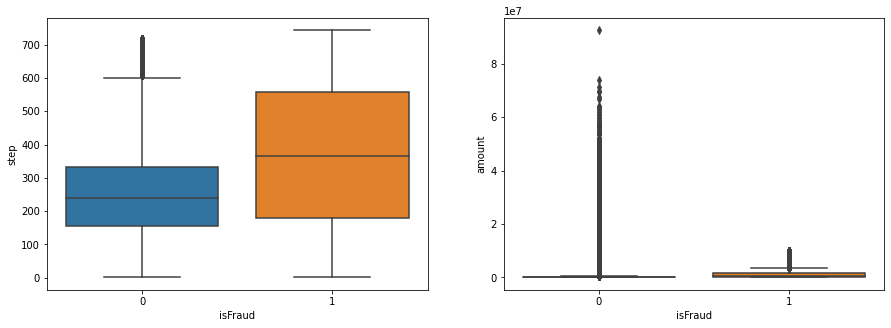

In [8]:
plt.figure(figsize =(15,5))
plt.subplot(1,2,1)
sns.boxplot(x = 'isFraud', y = 'step', data = df)
plt.subplot(1,2,2)
sns.boxplot(x = 'isFraud', y = 'amount', data = df)

é possivel perceber que as transações fraudulentas ocorrem em media no 15.º dia do Mês, e o valor medio das transações fraudulentas é maior que o das transações sem fraude.